# Conditional Neural Processes (CNP) for XENON.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime
import numpy as np
import pandas as pd
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml
# may have to run this cell 2 times for an error to go away

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
with open("../xenon/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_predict"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out  = config_file["path_settings"]["path_out_cnp"]
version   = config_file["path_settings"]["version"]
iteration = config_file["path_settings"]["iteration"]
fidelity  = config_file["path_settings"]["fidelity"]

path_to_files_predict = config_file["path_settings"]["path_to_files_predict"]
if "validation" in path_to_files_predict[0]:
    output_suffix = "output_validation"
else:
    output_suffix = "output"

In [12]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])

In [13]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'{path_out}/cnp_{version}_model_15epochs.pth'))
model.eval()

DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=42, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

Batch :0
2025-11-03 20:42:09 Iteration: 0/0, train loss: 0.8111 (vs BCE 0.6897)


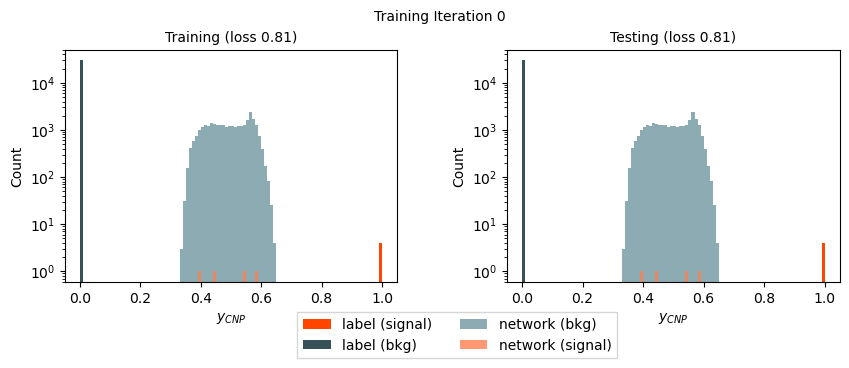

Batch :1
Batch :2
Batch :3
Batch :4
Batch :5
Batch :6
Batch :7
Batch :8
Batch :9
Batch :10
Batch :11
Batch :12
Batch :13
Batch :14
Batch :15
Batch :16
Batch :17
Batch :18
Batch :19
Batch :20
Batch :21
Batch :22
Batch :23
Batch :24
Batch :25
Batch :26
Batch :27
Batch :28
Batch :29
Batch :30
Batch :31
Batch :32
Batch :33
Batch :34
Batch :35
Batch :36
Batch :37
Batch :38
Batch :39
Batch :40
Batch :41
Batch :42
Batch :43
Batch :44
Batch :45
Batch :46
Batch :47
Batch :48
Batch :49
Batch :50
Batch :51
Batch :52
Batch :53
Batch :54
Batch :55
Batch :56
Batch :57
Batch :58
Batch :59
Batch :60
Batch :61
Batch :62
Batch :63
Batch :64
Batch :65
Batch :66
Batch :67
Batch :68
Batch :69
Batch :70
Batch :71
Batch :72
Batch :73
Batch :74
Batch :75
Batch :76
Batch :77
Batch :78
Batch :79
Batch :80
Batch :81
Batch :82
Batch :83
Batch :84
Batch :85
Batch :86
Batch :87
Batch :88
Batch :89
Batch :90
Batch :91
Batch :92
Batch :93
Finished full dataset pass. Starting new epoch! 
Batch :94
Batch :95
Batch :96


In [14]:
bce = nn.BCELoss()

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_{output_suffix}_15epochs.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader

    # Shuffle the files in the dataset for randomized prediction order
    dataloader_predict.dataset.shuffle_files()

    for b, batch in enumerate(dataloader_predict):
        # Safety check: Skip empty batches
        if batch.numel() == 0:
            print(f"Warning: Skipping empty batch at iteration {b}")
            continue
            
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0].detach().numpy()
        print(f"Batch :{it_batch}")
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_{output_suffix}_15epochs.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1


Marginalized plots saved to: ../xenon/out/cnp/cnp_v50.0_output_15epochs.png


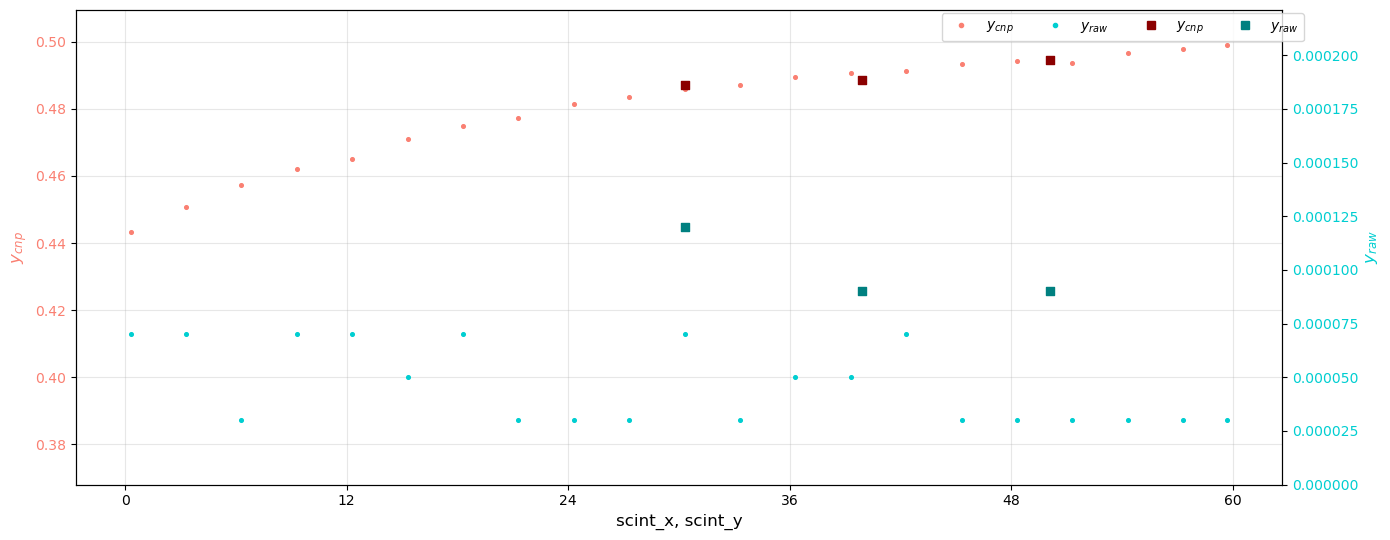

In [8]:
# Generate marginalized plots for all parameters
try:
    fig = plotting.get_marginialized_all(config_file=config_file)
    fig.savefig(f'{path_out}/cnp_{version}_{output_suffix}.png', dpi=300, bbox_inches='tight')
    print(f"Marginalized plots saved to: {path_out}/cnp_{version}_{output_suffix}_15epochs.png")
except Exception as e:
    print(f"Error generating marginalized plots: {e}")
    import traceback
    traceback.print_exc()

2D heatmaps saved to: ../xenon/out/cnp/cnp_v30.0_output_heatmaps.png
Error heatmap saved to: ../xenon/out/cnp/cnp_v30.0_output_error_heatmap.png

Summary Statistics:
  y_raw: min=0.0000, max=0.0005, mean=0.0001
  y_cnp: min=0.4465, max=0.4955, mean=0.4620
  Error: min=0.4465, max=0.4954, mean=0.4619
  MAE: 0.4619
  RMSE: 0.4621


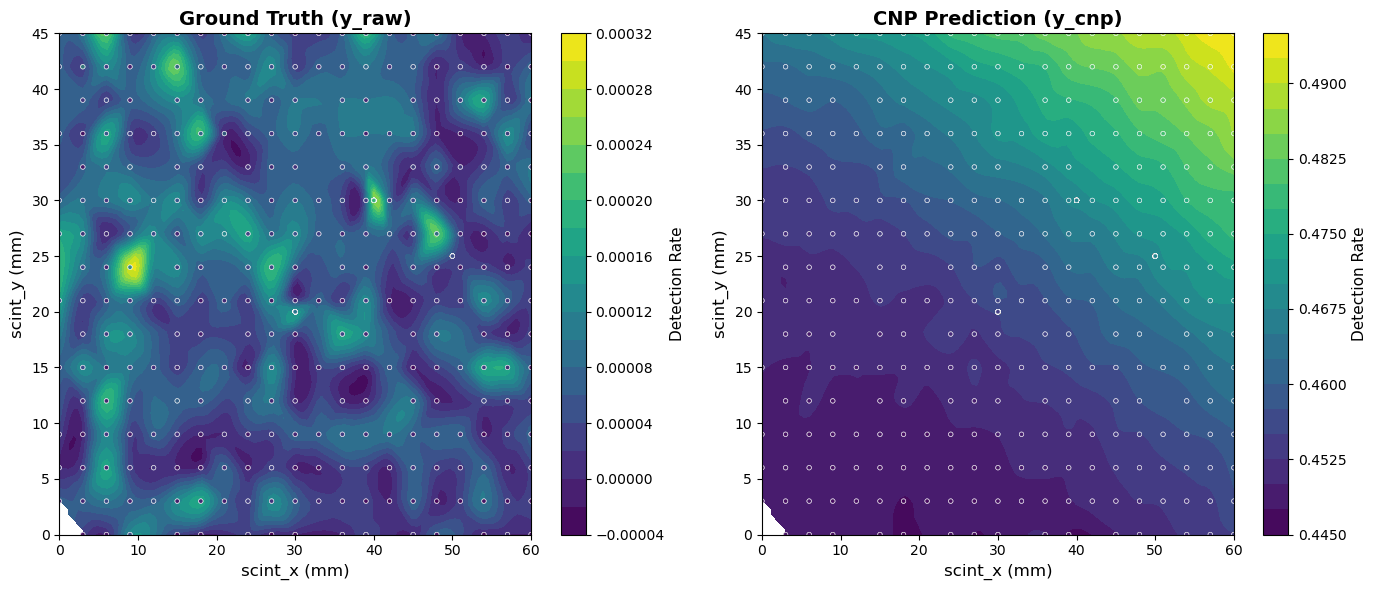

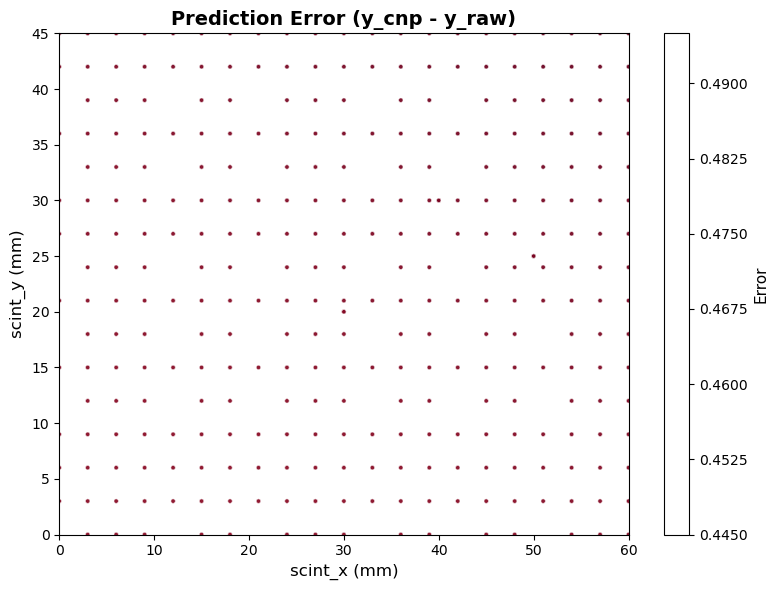

In [9]:
# Generate 2D heatmaps for y_raw and y_cnp based on scint_x and scint_y
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

try:
    # Read the CSV file
    df = pd.read_csv(f'{path_out}/cnp_{version}_{output_suffix}.csv')
    
    # Extract the relevant columns
    scint_x = df['scint_x'].values
    scint_y = df['scint_y'].values
    y_raw = df['y_raw'].values
    y_cnp = df['y_cnp'].values
    
    # Create a grid for interpolation
    grid_x, grid_y = np.mgrid[
        scint_x.min():scint_x.max():100j,
        scint_y.min():scint_y.max():100j
    ]
    
    # Interpolate the data onto the grid
    grid_y_raw = griddata((scint_x, scint_y), y_raw, (grid_x, grid_y), method='cubic')
    grid_y_cnp = griddata((scint_x, scint_y), y_cnp, (grid_x, grid_y), method='cubic')
    
    # Create the figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot y_raw heatmap
    im1 = axes[0].contourf(grid_x, grid_y, grid_y_raw, levels=20, cmap='viridis')
    axes[0].scatter(scint_x, scint_y, c=y_raw, s=10, cmap='viridis', edgecolor='white', linewidth=0.5, alpha=0.6)
    axes[0].set_xlabel('scint_x (mm)', fontsize=12)
    axes[0].set_ylabel('scint_y (mm)', fontsize=12)
    axes[0].set_title('Ground Truth (y_raw)', fontsize=14, fontweight='bold')
    cbar1 = plt.colorbar(im1, ax=axes[0])
    cbar1.set_label('Detection Rate', fontsize=11)
    
    # Plot y_cnp heatmap
    im2 = axes[1].contourf(grid_x, grid_y, grid_y_cnp, levels=20, cmap='viridis')
    axes[1].scatter(scint_x, scint_y, c=y_cnp, s=10, cmap='viridis', edgecolor='white', linewidth=0.5, alpha=0.6)
    axes[1].set_xlabel('scint_x (mm)', fontsize=12)
    axes[1].set_ylabel('scint_y (mm)', fontsize=12)
    axes[1].set_title('CNP Prediction (y_cnp)', fontsize=14, fontweight='bold')
    cbar2 = plt.colorbar(im2, ax=axes[1])
    cbar2.set_label('Detection Rate', fontsize=11)
    
    plt.tight_layout()
    
    # Save the figure
    heatmap_path = f'{path_out}/cnp_{version}_{output_suffix}_heatmaps.png'
    fig.savefig(heatmap_path, dpi=300, bbox_inches='tight')
    print(f"2D heatmaps saved to: {heatmap_path}")
    
    # Also create a difference/error heatmap
    fig_diff, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    grid_diff = grid_y_cnp - grid_y_raw
    im_diff = ax.contourf(grid_x, grid_y, grid_diff, levels=20, cmap='RdBu_r', vmin=-np.abs(grid_diff).max(), vmax=np.abs(grid_diff).max())
    ax.scatter(scint_x, scint_y, c=y_cnp - y_raw, s=10, cmap='RdBu_r', 
               vmin=-(y_cnp - y_raw).max(), vmax=(y_cnp - y_raw).max(),
               edgecolor='white', linewidth=0.5, alpha=0.6)
    ax.set_xlabel('scint_x (mm)', fontsize=12)
    ax.set_ylabel('scint_y (mm)', fontsize=12)
    ax.set_title('Prediction Error (y_cnp - y_raw)', fontsize=14, fontweight='bold')
    cbar_diff = plt.colorbar(im_diff, ax=ax)
    cbar_diff.set_label('Error', fontsize=11)
    
    plt.tight_layout()
    
    # Save the difference heatmap
    diff_path = f'{path_out}/cnp_{version}_{output_suffix}_error_heatmap.png'
    fig_diff.savefig(diff_path, dpi=300, bbox_inches='tight')
    print(f"Error heatmap saved to: {diff_path}")
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"  y_raw: min={y_raw.min():.4f}, max={y_raw.max():.4f}, mean={y_raw.mean():.4f}")
    print(f"  y_cnp: min={y_cnp.min():.4f}, max={y_cnp.max():.4f}, mean={y_cnp.mean():.4f}")
    print(f"  Error: min={(y_cnp - y_raw).min():.4f}, max={(y_cnp - y_raw).max():.4f}, mean={(y_cnp - y_raw).mean():.4f}")
    print(f"  MAE: {np.mean(np.abs(y_cnp - y_raw)):.4f}")
    print(f"  RMSE: {np.sqrt(np.mean((y_cnp - y_raw)**2)):.4f}")
    
except Exception as e:
    print(f"Error generating 2D heatmaps: {e}")
    import traceback
    traceback.print_exc()